##### Tous les imports nécessaires

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt, iirnotch
from io import StringIO
from scipy.fftpack import fft, ifft


##### On charge les données et on les nettoie

In [2]:
file_path1 = 'emg+dataset+in+lower+limb/SEMG_DB1/N_TXT/1Nmar.txt'

def load_and_process_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        content = '\n'.join(content.split('\n')[6:])
    
    data = pd.read_csv(StringIO(content), sep='\t', header=None, names=['RF', 'BF', 'VM', 'ST', 'FX'])
    data.dropna(inplace=True)
    data['Time'] = data.index
    return data

#Filtre passe-bande
def bandpass_filter(data, lowcut=20, highcut=450, fs=1000, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

#Filtre notch
def notch_filter(data, notch_freq=50, fs=1000, quality_factor=30):
    nyquist = 0.5 * fs
    freq = notch_freq / nyquist
    b, a = iirnotch(freq, quality_factor)
    return filtfilt(b, a, data)

#Normalisation des données
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

data = load_and_process_data(file_path1)

# Application des filtres et de la normalisation sur chaque signal
for col in ['RF', 'BF', 'VM', 'ST']:
    data[col] = bandpass_filter(data[col])
    data[col] = notch_filter(data[col])
    data[col] = normalize_data(data[col])

print(data.head())

         RF        BF        VM        ST    FX  Time
0  0.522072  0.377270  0.478975  0.442357  57.6     0
1  0.517630  0.399627  0.458251  0.462805  57.5     1
2  0.520627  0.376228  0.466271  0.471472  57.3     2
3  0.521994  0.378373  0.487813  0.461059  57.1     3
4  0.531031  0.413314  0.515392  0.437844  56.9     4


##### Obtention des maximums locaux pour déterminer les cycles

In [3]:
# Détection des pics pour identifier les cycles de marche
peaks, _ = find_peaks(data['FX'], height=np.mean(data['FX']))
print(f'Nombre de pics détectés : {len(peaks)}')
print(peaks)

#On determine la durée d'un cycle moyen
cycle_lengths = np.diff(peaks)
mean_cycle_length = np.mean(cycle_lengths)
print(f'Longueur moyenne des cycles : {mean_cycle_length}')

# Décalage des cycles pour que le pic soit à 70%
shift_ratio = 0.7
adjusted_peaks = []

for i in range(len(peaks)):
    shift_amount = int(mean_cycle_length * shift_ratio)
    adjusted_start = max(0, peaks[i] - shift_amount)  # Éviter les index négatifs
    adjusted_peaks.append(adjusted_start)

# Vérification des cycles estimés en l'absence d'un pic
while adjusted_peaks[-1] + mean_cycle_length < len(data):
    new_cycle_start = adjusted_peaks[-1] + mean_cycle_length
    adjusted_peaks.append(new_cycle_start)
    
print(f'Nombre de débuts de cycles ajustés : {len(adjusted_peaks)}')
print(adjusted_peaks)

Nombre de pics détectés : 4
[1144 2380 3649 4930]
Longueur moyenne des cycles : 1262.0
Nombre de débuts de cycles ajustés : 5
[261, 1497, 2766, 4047, 5309.0]


##### Affichage du du graphique de flexion du genoux avec les differents cycles

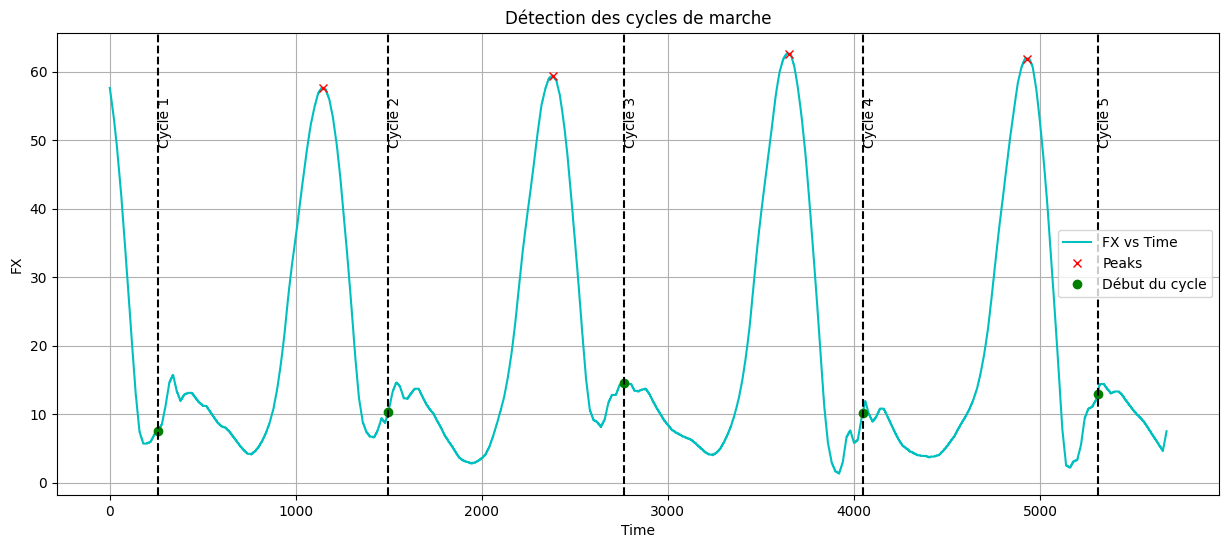

In [4]:
# Affichage du signal FX avec les cycles marqués
plt.figure(figsize=(15, 6))
plt.plot(data['Time'], data['FX'], label='FX vs Time', color='c')
plt.plot(data['Time'][peaks], data['FX'][peaks], 'rx', label='Peaks')
plt.plot(data['Time'][adjusted_peaks], data['FX'][adjusted_peaks], 'go', label='Début du cycle')

for i, start in enumerate(adjusted_peaks):
    plt.axvline(x=data['Time'][start], color='k', linestyle='--')
    plt.text(data['Time'][start], max(data['FX']) * 0.9, f'Cycle {i+1}', rotation=90, verticalalignment='top')

plt.xlabel('Time')
plt.ylabel('FX')
plt.title('Détection des cycles de marche')
plt.legend()
plt.grid(True)
plt.show()


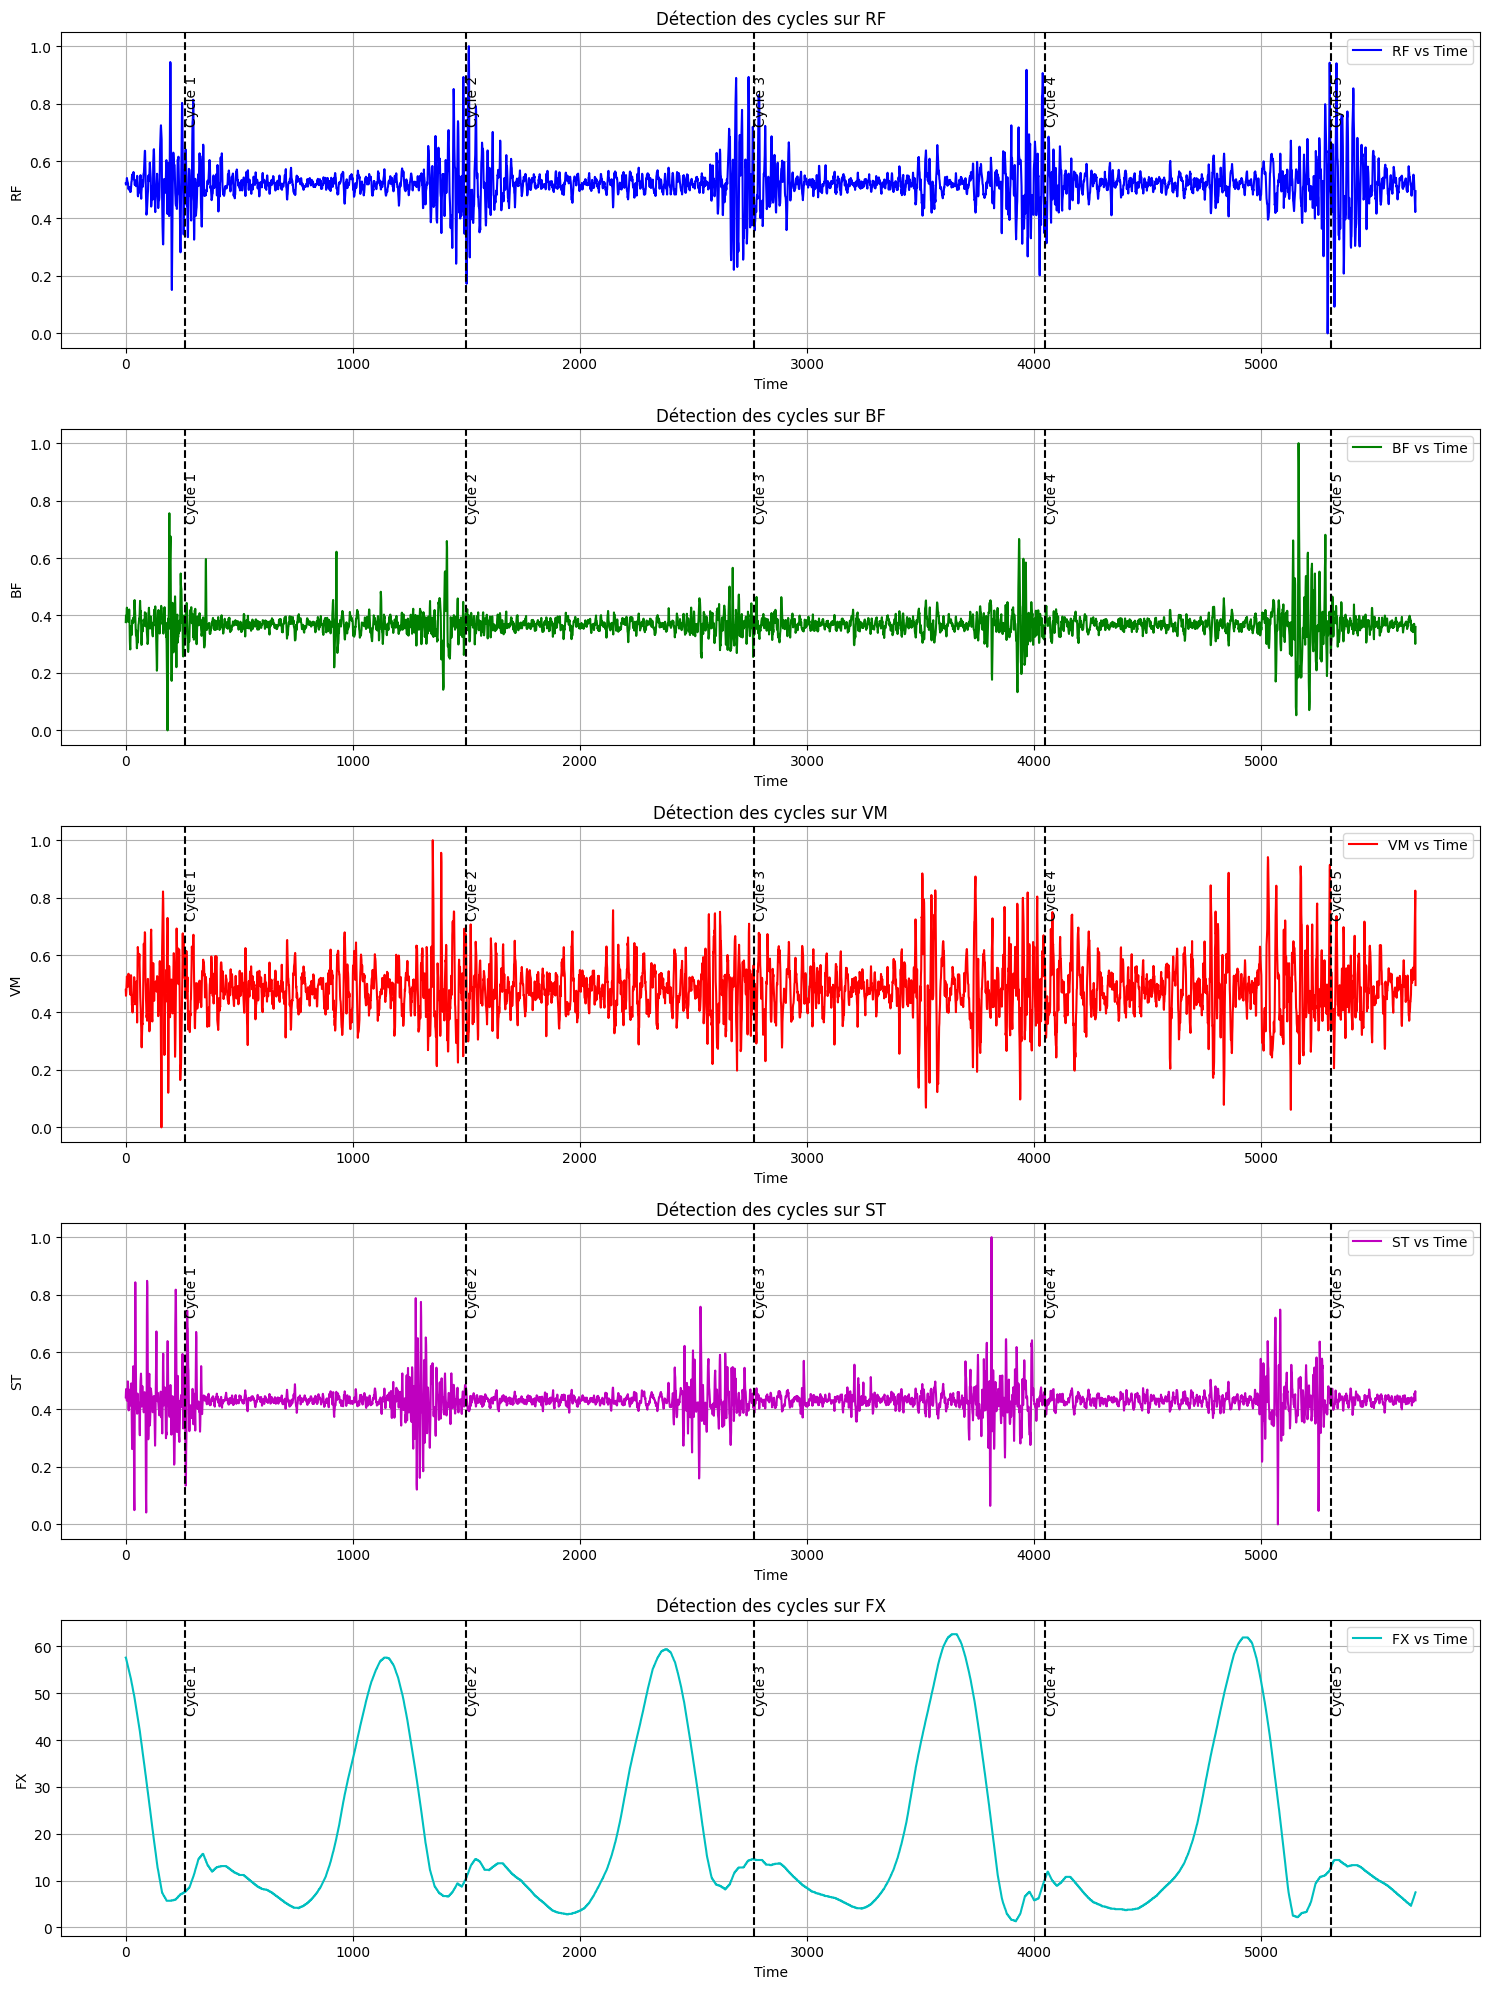

In [5]:
# Liste des colonnes à afficher
columns = ['RF', 'BF', 'VM', 'ST', 'FX']
colors = ['b', 'g', 'r', 'm', 'c']

# Création des graphiques pour chaque signal avec les cycles marqués
fig, axs = plt.subplots(len(columns), figsize=(15, 20))
for i, col in enumerate(columns):
    axs[i].plot(data['Time'], data[col], label=f'{col} vs Time', color=colors[i])
    for j, start in enumerate(adjusted_peaks):
        axs[i].axvline(x=data['Time'][start], color='k', linestyle='--')
        axs[i].text(data['Time'][start], max(data[col]) * 0.9, f'Cycle {j+1}', rotation=90, verticalalignment='top')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel(col)
    axs[i].set_title(f'Détection des cycles sur {col}')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

##### DOMAINE TEMPORELLE

RMS

In [6]:
# Convert float values in adjusted_peaks to integers
adjusted_peaks = [int(peak) for peak in adjusted_peaks]

# RMS (Root Mean Square) pour chaque cycle
rms_values_RF = []
rms_values_BF = []
rms_values_VM = []
rms_values_ST = []
for i in range(len(adjusted_peaks) - 1):
    start = adjusted_peaks[i]
    end = adjusted_peaks[i + 1]
    rms_RF = np.sqrt(np.mean(data['RF'][start:end] ** 2))
    rms_values_RF.append(rms_RF)
    rms_BF = np.sqrt(np.mean(data['BF'][start:end] ** 2))
    rms_values_BF.append(rms_BF)
    rms_VM = np.sqrt(np.mean(data['VM'][start:end] ** 2))
    rms_values_VM.append(rms_VM)
    rms_ST = np.sqrt(np.mean(data['ST'][start:end] ** 2))
    rms_values_ST.append(rms_ST)


print(rms_values_RF)
print(rms_values_BF)
print(rms_values_VM)
print(rms_values_ST)

[0.5246820668499975, 0.5271224771358698, 0.5259840897829026, 0.5247872755591332]
[0.3702655511980168, 0.36942446075588126, 0.3703267507074388, 0.37336891008629114]
[0.48817279377322637, 0.487202438815936, 0.49292639898064605, 0.49446717456655476]
[0.4354661237525875, 0.43431062446811886, 0.4356371948752036, 0.4350650855554701]


MAV

In [7]:
#MAV (Mean Absolute Value) pour chaque cycle

mav_values_RF = []
mav_values_BF = []
mav_values_VM = []
mav_values_ST = []

for i in range(len(adjusted_peaks) - 1):
    start = adjusted_peaks[i]
    end = adjusted_peaks[i + 1]
    mav_RF = np.mean(np.abs(data['RF'][start:end]))
    mav_values_RF.append(mav_RF)
    mav_BF = np.mean(np.abs(data['BF'][start:end]))
    mav_values_BF.append(mav_BF)
    mav_VM = np.mean(np.abs(data['VM'][start:end]))
    mav_values_VM.append(mav_VM)
    mav_ST = np.mean(np.abs(data['ST'][start:end]))
    mav_values_ST.append(mav_ST)

print(mav_values_RF)
print(mav_values_BF)
print(mav_values_VM)
print(mav_values_ST)

[0.5218294603354064, 0.5221228599239448, 0.5218631190593642, 0.5215094127299689]
[0.36823542920067137, 0.36843549541705545, 0.3682599403981753, 0.3683629539891554]
[0.48131057913928954, 0.4807531145624334, 0.481398140899656, 0.4811423793147724]
[0.4323950073919921, 0.4324442599903831, 0.4326095195663578, 0.4323933554635272]


##### Domainne fréquentielle


Transformée de Fourier

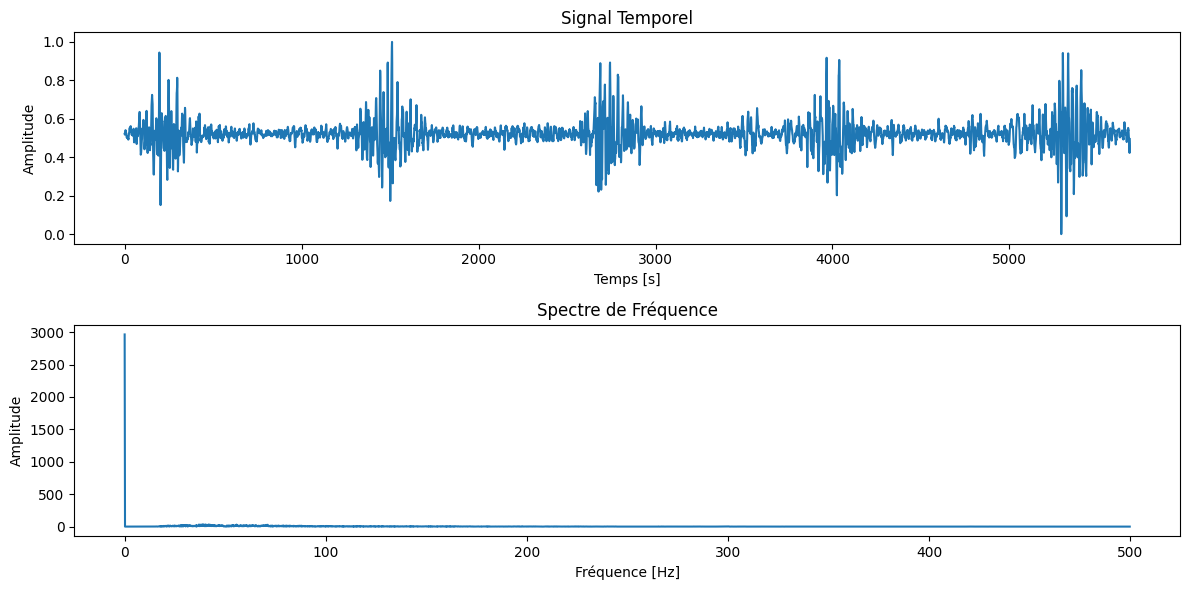

In [25]:
fs = 1000  # Fréquence d'échantillonnage (1000 Hz)
T = 1 / fs  # Période d'échantillonnage

# Calcul de la Transformée de Fourier Discrète
X = np.fft.fft(data['RF'])

# Calcul des fréquences associées
n = len(data['RF'])  # Nombre d'échantillons
frequencies = np.fft.fftfreq(n, T)

# Sélection des fréquences positives pour une meilleure visualisation
positive_frequencies = frequencies[:n // 2]
positive_X = X[:n // 2]

# Calcul de l'amplitude du signal fréquentiel
amplitude = np.abs(positive_X)

# Tracer le signal temporel
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(data['Time'], data['RF'])
plt.title('Signal Temporel')
plt.xlabel('Temps [s]')
plt.ylabel('Amplitude')

# Tracer le spectre de fréquence (amplitude)
plt.subplot(2, 1, 2)
plt.plot(positive_frequencies, amplitude)
plt.title('Spectre de Fréquence')
plt.xlabel('Fréquence [Hz]')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()







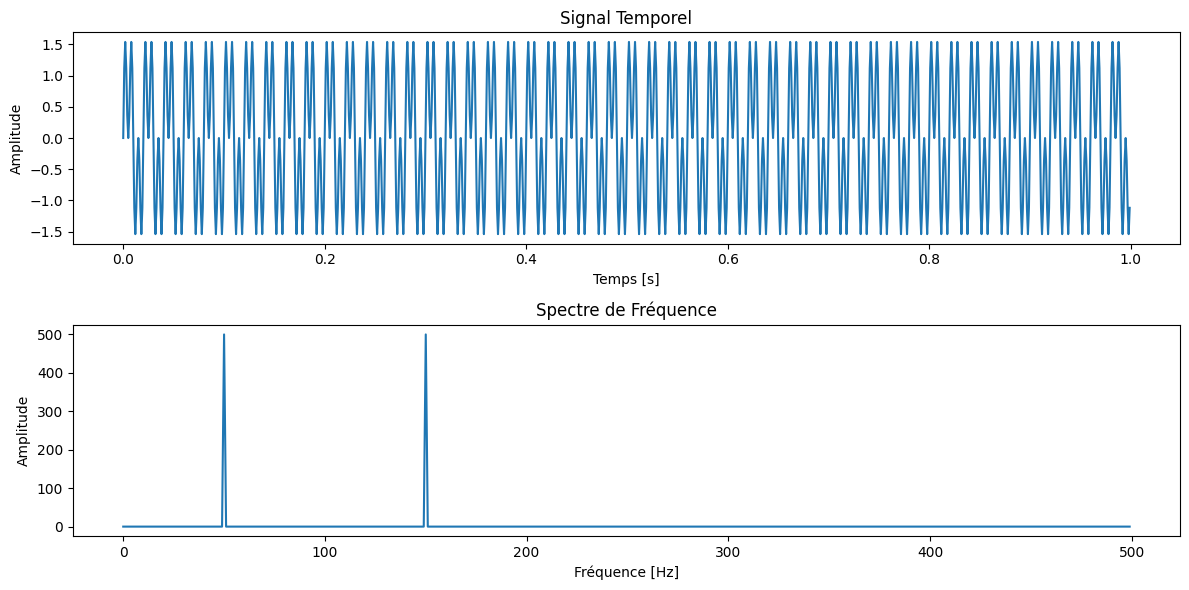

In [23]:
# Création d'un signal temporel
# Exemple : un signal composé de deux sinusoïdes
fs = 1000  # Fréquence d'échantillonnage (1000 Hz)
T = 1 / fs  # Période d'échantillonnage
t = np.arange(0, 1, T)  # 1 seconde d'échantillons

# Signal temporel (ici une somme de sinusoïdes)
f1 = 50  # Fréquence de la première sinusoïde
f2 = 150  # Fréquence de la deuxième sinusoïde
x = np.sin(2 * np.pi * f1 * t) + np.sin(2 * np.pi * f2 * t)

# Calcul de la Transformée de Fourier Discrète
X = np.fft.fft(x)

# Calcul des fréquences associées
n = len(x)  # Nombre d'échantillons
frequencies = np.fft.fftfreq(n, T)

# Sélection des fréquences positives pour une meilleure visualisation
positive_frequencies = frequencies[:n // 2]
positive_X = X[:n // 2]

# Calcul de l'amplitude du signal fréquentiel
amplitude = np.abs(positive_X)

# Tracer le signal temporel
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, x)
plt.title('Signal Temporel')
plt.xlabel('Temps [s]')
plt.ylabel('Amplitude')

# Tracer le spectre de fréquence (amplitude)
plt.subplot(2, 1, 2)
plt.plot(positive_frequencies, amplitude)
plt.title('Spectre de Fréquence')
plt.xlabel('Fréquence [Hz]')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()